In [10]:
import cnn
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
df = pd.read_csv('./us_change.csv')

df = (df
    .assign(date=pd.PeriodIndex(df.Quarter.str.replace(' ', ''), freq='Q').to_timestamp())
    .set_index('date'))

df.head()

,Quarter,Consumption,Income,Production,Savings,Unemployment
date,,,,,,
1970-01-01,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
1970-10-01,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971-01-01,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1


In [ ]:
# Configurações do Grid Search
kernel_sizes = [3, 5, 7, 9]
hidden_channels = [8, 16, 32, 64]
num_layers = [1, 2, 3, 4]
learning_rate = 0.01
epochs = 50

In [62]:
X_no_norm, y_no_norm = cnn.preprocess_data(df, normalize=False)
results_no_norm = cnn.grid_search(X_no_norm, y_no_norm, kernel_sizes, hidden_channels, num_layers, learning_rate, epochs)
results_no_norm

,Kernel Size,Hidden Channels,Num Layers,MSE Mean,MSE Std
0,3,8,1,0.191084,0.031325
1,3,16,1,0.145080,0.020794
2,3,32,1,0.111874,0.015285
3,3,64,1,0.123697,0.016929
4,5,8,1,0.188091,0.010980
...,...,...,...,...,...
59,7,64,4,0.113740,0.019368
60,9,8,4,0.091558,0.015865
61,9,16,4,0.092888,0.010758
62,9,32,4,0.085133,0.007476


In [63]:
best_params = results_no_norm.sort_values('MSE Mean', ascending=True).iloc[0]
best_params

Kernel Size         7.000000
Hidden Channels    16.000000
Num Layers          4.000000
MSE Mean            0.083202
MSE Std             0.005191
Name: 57, dtype: float64

In [72]:
best_kernel_size = best_params['Kernel Size'].astype(int)
best_hidden_channels = best_params['Hidden Channels'].astype(int)
best_num_layers = best_params['Num Layers'].astype(int)

X_norm, y_norm = cnn.preprocess_data(df, normalize=True)
results_norm = cnn.grid_search(X_norm, y_norm, [best_kernel_size], [best_hidden_channels], [best_num_layers], learning_rate, epochs)
results_norm["Normalization"] = "Yes"
results_norm["Quarter"] = "No"

X_quarter, y_quarter = cnn.preprocess_data(df, normalize=False, encode_quarter=True)
results_quarter = cnn.grid_search(X_quarter, y_quarter, [best_kernel_size], [best_hidden_channels], [best_num_layers], learning_rate, epochs)
results_quarter["Normalization"] = "No"
results_quarter["Quarter"] = "Yes"

X_both, y_both = cnn.preprocess_data(df, normalize=True, encode_quarter=True)
results_both = cnn.grid_search(X_both, y_both, [best_kernel_size], [best_hidden_channels], [best_num_layers], learning_rate, epochs)
results_both["Normalization"] = "Yes"
results_both["Quarter"] = "Yes"

best_params_df = best_params.to_frame().T
best_params_df["Normalization"] = "No"
best_params_df["Quarter"] = "No"

results = pd.concat([results_norm, results_quarter, results_both, best_params_df])
results.drop(columns=["Kernel Size", "Hidden Channels", "Num Layers"], inplace=True)
results


,MSE Mean,MSE Std,Normalization,Quarter
0,0.059690,0.003399,Yes,No
0,0.128068,0.024840,No,Yes
0,0.076810,0.006900,Yes,Yes
57,0.083202,0.005191,No,No


MSE on test set: 0.04244096949696541


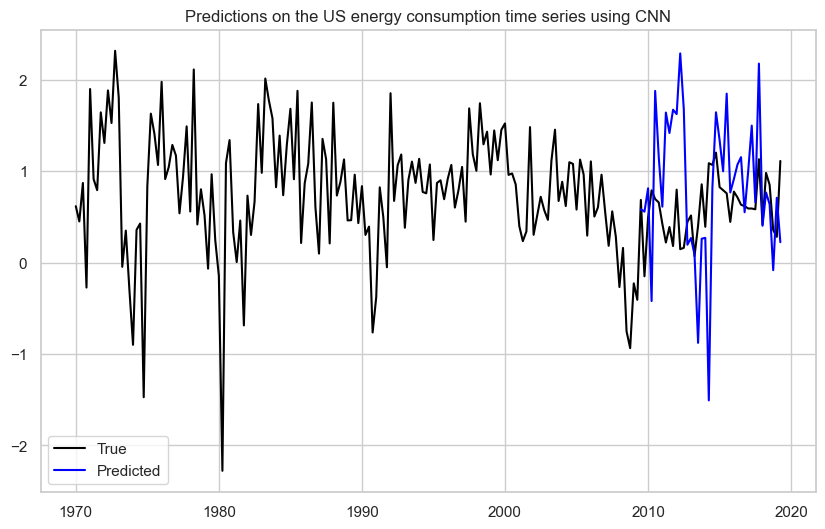

In [79]:
# Plot time series
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

import torch

# Train model with the first 80% of the time series
X_train = torch.tensor(X_norm[:int(0.8*len(X_norm))], dtype=torch.float32)
y_train = torch.tensor(y_norm[:int(0.8*len(y_norm))], dtype=torch.float32)
X_test = torch.tensor(X_norm[int(0.8*len(X_norm)):], dtype=torch.float32)
y_test = torch.tensor(y_norm[int(0.8*len(y_norm)):], dtype=torch.float32)

model, mse = cnn.train_model(X_train, y_train, X_test, y_test, X_train.shape[1], best_kernel_size, best_hidden_channels, best_num_layers, learning_rate, 100)
print(f'MSE on test set: {mse}')

# Predictions for all time series
X = torch.tensor(X_norm, dtype=torch.float32)
y = torch.tensor(y_norm, dtype=torch.float32)

predictions = model(X).detach().numpy()

# Plot predictions highlighting the test set
seen_dates = df.index[int(0.8*len(df)):]
seen_dates

ax.plot(df.index, df['Consumption'], label='True', color='black')
ax.plot(seen_dates, predictions[:len(seen_dates)], label='Predicted', color='blue')
plt.title('Predictions on the US energy consumption time series using CNN')
ax.legend()
